In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
precip_12 = pd.read_sql("select measurement.date, measurement.prcp from measurement\
    where measurement.date < '2017-08-23' and\
    measurement.date > '2016-08-23';", engine)


In [13]:
precip_12.set_index('date', inplace=True)


In [14]:
precip_12.sort_index(inplace=True)

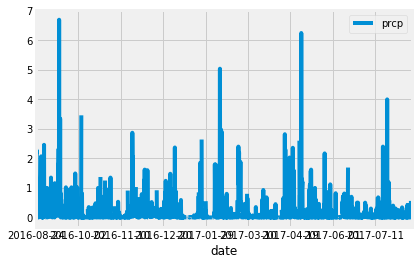

In [15]:
precip_12.plot()

![precipitation](Images/precipitation.png)

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_12.describe()

prcp
count  2011.000000
mean      0.176549
std       0.460667
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
station = engine.execute("select count(distinct measurement.station) as cnt\
               from measurement").fetchall()
start = '2012-02-02'

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station = engine.execute("select measurement.station, count(measurement.station) as cnt\
               from measurement \
               group by measurement.station\
               order by cnt desc").fetchall()
station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

results = engine.execute("select measurement.station,\
                        min(measurement.tobs),\
                        max(measurement.tobs),\
                        avg(measurement.tobs)\
                        from measurement\
                        where measurement.station ='USC00519281'").fetchall()

In [24]:
print(f"Station ID: {results[0][0]}\nLowest Temperature recorded: {results[0][1]} \n\
Highest Temperature recorded: {results[0][2]} \n\
Average Temperature: {results[0][3]}")

Station ID: USC00519281
Lowest Temperature recorded: 54.0 
Highest Temperature recorded: 85.0 
Average Temperature: 71.66378066378067


In [25]:
#Find last date of data for Station with the most activity
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [26]:
#set query date to 12 months prior of last date entry

query_date = dt.date(2016, 2, 2) - dt.timedelta(weeks=52)
query_date

datetime.date(2015, 2, 3)

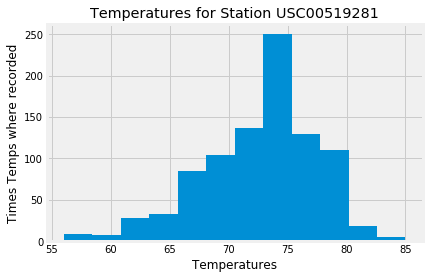

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = ['Measurement.station', 'Measurement.date','Measurement.prcp', 'Measurement.tobs']
data2 = session.query(*sel).filter(Measurement.station == 'USC00519281').\
filter(Measurement.date > query_date).all()
station_db = pd.DataFrame(data2)
station_db.set_index('Measurement.date')

station_db['Measurement.tobs'].plot.hist(Measurement, bins = 12)
plt.title('Temperatures for Station USC00519281')
plt.xlabel('Temperatures')
plt.ylabel('Times Temps where recorded')
plt.show()


In [28]:
station_db

Measurement.station Measurement.date  Measurement.prcp  Measurement.tobs
0           USC00519281       2015-02-04              1.29              74.0
1           USC00519281       2015-02-05              0.00              66.0
2           USC00519281       2015-02-06              0.00              58.0
3           USC00519281       2015-02-07              0.00              70.0
4           USC00519281       2015-02-08              0.00              66.0
..                  ...              ...               ...               ...
912         USC00519281       2017-08-14              0.00              77.0
913         USC00519281       2017-08-15              0.32              77.0
914         USC00519281       2017-08-16              0.12              76.0
915         USC00519281       2017-08-17              0.01              76.0
916         USC00519281       2017-08-18              0.06              79.0

[917 rows x 4 columns]

![precipitation](Images/station-histogram.png)

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Hawaii vacation 05/26/2020 - 06/05-2020
my_trip = calc_temps('2017-05-26', '2017-06-05')
my_trip

[(69.0, 76.84375, 82.0)]

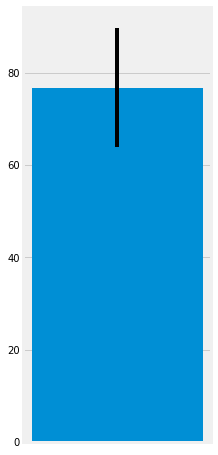

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8))

plt.bar(x=1, y=0, yerr=my_trip[0][2]-my_trip[0][0], height=my_trip[0][1], align='center')
plt.xticks([])
plt.show()


In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
total_rain = session.query(*sel).group_by(Station.name).filter(Measurement.date >= '2017-05-26').filter(Measurement.date <= '2017-06-05').\
    filter(Station.station == Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

total_rain

[('WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.1999999999999997),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.34),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.1099999999999999),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.44),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.33000000000000007),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.26),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [36]:
# Plot the daily normals as an area plot with `stacked=False`
